In [1]:
using Plots
using Random
using Statistics
using Enzyme

In [2]:
@views function gravity(pos :: AbstractArray{Float64, 2}) :: AbstractArray{Float64, 2}
    vec_x = pos[1, :] .- pos[1, :]'
    vec_y = pos[2, :] .- pos[2, :]'
    vec_z = pos[3, :] .- pos[3, :]'

    r_sq = (vec_x.^2 + vec_y.^2 + vec_z.^2) .+ 1e-5

    force_x = -vec_x ./ r_sq
    force_y = -vec_y ./ r_sq
    force_z = -vec_z ./ r_sq

    force_x = sum(force_x, dims=2)
    force_y = sum(force_y, dims=2)
    force_z = sum(force_z, dims=2)

    force = [force_x force_y force_z]

    return transpose(force)
end

gravity (generic function with 1 method)

In [3]:
function kdk!(
    pos_t0 :: AbstractArray{Float64, 2},
    vel_t0 :: AbstractArray{Float64, 2},
    pos_t1 :: AbstractArray{Float64, 2},
    vel_t1 :: AbstractArray{Float64, 2},
    dt :: Float64) :: Nothing
    
    # compute a(t)
    force_t0 = gravity(pos_t0)
    # v(t + dt/2) = v(t) + a(t) * dt/2
    vel_t1 .+= force_t0 .* dt / 2
    # x(t + dt) = x(t) + v(t + dt/2) * dt
    pos_t1 .+= vel_t1 .* dt
    # a(t + dt)
    force_t1 = gravity(pos_t1)
    # v(t + dt) = v(t + dt/2) + a(t + dt) * dt/2
    vel_t1 .+= force_t1 .* dt / 2    

    return nothing
end

kdk! (generic function with 1 method)

In [4]:
@views function forward!(
    pos :: AbstractArray{Float64, 3},
    vel :: AbstractArray{Float64, 3},
    dt :: Float64,
    n_steps :: Int) :: Nothing

    for i in 1:n_steps
        kdk!(
            pos[i, :, :],
            vel[i, :, :],
            pos[i+1, :, :],
            vel[i+1, :, :],
            dt)
    end

    return nothing
end

forward! (generic function with 1 method)

Initialize and compute the forward pass

In [5]:
n_particles = 50
n_steps = 200

pos = zeros(Float64, (n_steps+1, 3, n_particles))
vel = zeros(Float64, (n_steps+1, 3, n_particles))

pos_t0 = randn(Float64, (3, n_particles))

pos[1, :, :] .= pos_t0

forward!(pos, vel, 0.01, n_steps)

Let us define the loss function.

In [6]:
@views function loss!(
    pos_tn :: AbstractArray{Float64, 2},
    pos_tn_star :: AbstractArray{Float64, 2},
    loss :: AbstractArray{Float64, 1}) :: Nothing

    loss[1] = sum((pos_tn .- pos_tn_star).^2)

    return nothing
end

loss! (generic function with 1 method)

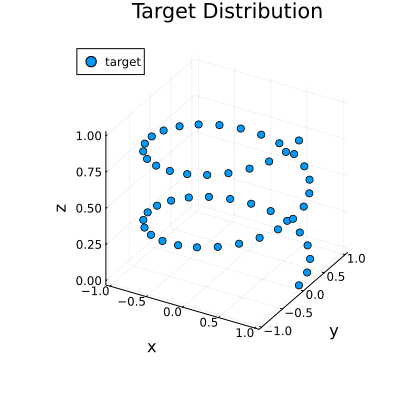

In [21]:
pos_tn_star = zeros(Float64, (3, n_particles))
pos_tn_star[1, :] = cos.(range(0, stop=4π, length=n_particles))
pos_tn_star[2, :] = sin.(range(0, stop=4π, length=n_particles))
pos_tn_star[3, :] = range(0, stop=1, length=n_particles)

# visualize the target distribution
scatter(
    pos_tn_star[1, :],
    pos_tn_star[2, :],
    pos_tn_star[3, :],
    label="target",
    xlabel="x",
    ylabel="y",
    zlabel="z",
    title="Target Distribution",
    legend=:topleft,
    size=(400, 400))

Now we can find the gradients of the loss with respect to the final positions of the particles.

In [22]:
loss_value = zeros(Float64, 1)
partial_loss = ones(Float64, 1)
partial_pos = ones(Float64, (n_steps+1, 3, n_particles))

@views begin
    autodiff(
        Reverse,
        loss!, 
        Duplicated(pos[end, :, :], partial_pos[end, :, :]),
        Const(pos_tn_star),
        Duplicated(loss_value, partial_loss))
end

partial_pos[end, :, :]

3×50 Matrix{Float64}:
 -0.930367  -0.972907  -0.757029   …  -0.800633  -0.989465  -0.946129
  0.995728   0.482207   0.0237059      2.00688    1.47135    1.05331
  0.966978   1.02715    0.951887      -0.965154  -0.919065  -0.984299

We introduce the backward function, which passes the gradients through the simulation.

In [25]:
@views function backward(
    pos :: AbstractArray{Float64, 3},
    vel :: AbstractArray{Float64, 3},
    partial_pos :: AbstractArray{Float64, 3},
    partial_vel :: AbstractArray{Float64, 3},
    dt :: Float64,
    n_steps :: Int) :: Nothing

    for i in n_steps:-1:2

        autodiff(
            Reverse,
            kdk!,
            Duplicated(pos[i, :, :], partial_pos[i, :, :]),
            Duplicated(vel[i, :, :], partial_vel[i, :, :]),
            Duplicated(pos[i-1, :, :], partial_pos[ i-1, :, :]),
            Duplicated(vel[i-1, :, :], partial_vel[i-1, :, :]),
            Const(dt)
        )
        
    end

end
    

backward (generic function with 1 method)

In [26]:
partial_vel = zeros(Float64, (n_steps+1, 3, n_particles))

backward(
    pos,
    vel,
    partial_pos,
    partial_vel,
    0.01,
    n_steps)

In [30]:
partial_pos[2, :, :]

3×50 Matrix{Float64}:
 1.65476e13  8.7241e12   -1.39925e11   1.84489e12  …  1.01782   1.01854   1.0
 4.05148e12  1.4364e13    1.61032e13   1.0469e12      1.0335    0.991725  1.0
 1.86477e13  1.47706e13   8.38348e12  -1.37747e12     0.947015  1.00997   1.0